In [ ]:
#Install Library
! pip install pyspark
! pip install pyspark_dist_explore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import libraries
import numpy as np
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
spark = SparkSession.builder \
        .master('local[*]') \
        .config('spark.executor.memory', '10gb') \
        .config("spark.cores.max", "8") \
        .config("spark.executor.cores", "6") \
        .getOrCreate()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Read data from csv
stress= spark.read.csv("train_data.csv", header=True, inferSchema=True)
original_data=spark.read.csv("test_user.csv", header=True, inferSchema=True)

In [ ]:
from pyspark.ml.stat import Correlation
#Drop unnecessary columsn from dataframe
cor_drop_columns = ['User', 'Time' ,'Stress Level']
cor_stress = stress.drop(*cor_drop_columns)
# Show the resulting DataFrame
cor_stress.show()

# Convert the remaining columns into a feature vector
assembler = VectorAssembler(inputCols=cor_stress.columns, outputCol="corfeatures")
cor_stress_assembled = assembler.transform(cor_stress).select("corfeatures")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(cor_stress_assembled, "corfeatures").head()
correlation_matrix_array = correlation_matrix[0].toArray()

# Display the correlation matrix
correlation_matrix_array

+--------------------+-------------------------+--------------------------+---------------------------+----------------------------+----------------------------+----------------------------+---------------------------+----------------------------+------------------------------+----------------------------+--------------------------+--------------------------+-------------------------+---------------------------+------------------+--------------------------------------+
|Active Energy (kcal)|Apple Exercise Time (min)|Basal Energy Burned (kcal)|Blood Oxygen Saturation (%)|Heart Rate [Min] (count/min)|Heart Rate [Max] (count/min)|Heart Rate [Avg] (count/min)|Heart Rate Variability (ms)|Respiratory Rate (count/min)|Resting Heart Rate (count/min)|Sleep Analysis [In Bed] (hr)|Sleep Analysis [Core] (hr)|Sleep Analysis [Deep] (hr)|Sleep Analysis [REM] (hr)|Sleep Analysis [Awake] (hr)|Step Count (count)|Walking Heart Rate Average (count/min)|
+--------------------+-------------------------+----

array([[ 1.        ,  0.18872616,  0.41766432, -0.11086569,  0.01825161,
         0.27538747,  0.20190452,  0.20388074,  0.26664847,  0.00313104,
        -0.04832437, -0.10256462,  0.28677275,  0.13171966, -0.08206866,
        -0.18875155,  0.08035176],
       [ 0.18872616,  1.        ,  0.20220444, -0.04241365,  0.0068539 ,
         0.13179657,  0.09666567,  0.07124251,  0.10955602, -0.0094506 ,
         0.00364405, -0.0508275 ,  0.16015   ,  0.06812226, -0.04059547,
        -0.09020969,  0.04589505],
       [ 0.41766432,  0.20220444,  1.        , -0.12577805,  0.02883474,
         0.29674253,  0.203348  ,  0.20949727,  0.27681   , -0.03104754,
        -0.04674559, -0.10054176,  0.31463752,  0.15263368, -0.09221091,
        -0.20339892,  0.08367978],
       [-0.11086569, -0.04241365, -0.12577805,  1.        , -0.04099983,
        -0.06192911, -0.06197059, -0.05837567, -0.07092824, -0.0141199 ,
         0.07826718,  0.00993711, -0.07412379, -0.05654562,  0.02254943,
         0.05548957

In [ ]:
#Import necesaary columns
selected_columns =['User']+['Time']+['Stress Level'] +['Blood Oxygen Saturation (%)']+['Heart Rate Variability (ms)']+['Respiratory Rate (count/min)']+['Sleep Analysis [Deep] (hr)']+['Sleep Analysis [REM] (hr)']+['Step Count (count)']+['Walking Heart Rate Average (count/min)']
stress=stress.select(selected_columns)
stress.show()

+----+----+------------+---------------------------+---------------------------+----------------------------+--------------------------+-------------------------+------------------+--------------------------------------+
|User|Time|Stress Level|Blood Oxygen Saturation (%)|Heart Rate Variability (ms)|Respiratory Rate (count/min)|Sleep Analysis [Deep] (hr)|Sleep Analysis [REM] (hr)|Step Count (count)|Walking Heart Rate Average (count/min)|
+----+----+------------+---------------------------+---------------------------+----------------------------+--------------------------+-------------------------+------------------+--------------------------------------+
|   1|   1|           0|                99.12609696|                72.25330354|                 22.78549485|               0.069538761|              0.947323601|       2726.643486|                           86.01065858|
|   1|   2|           0|                94.69942743|                81.50123507|                 22.75301124|       

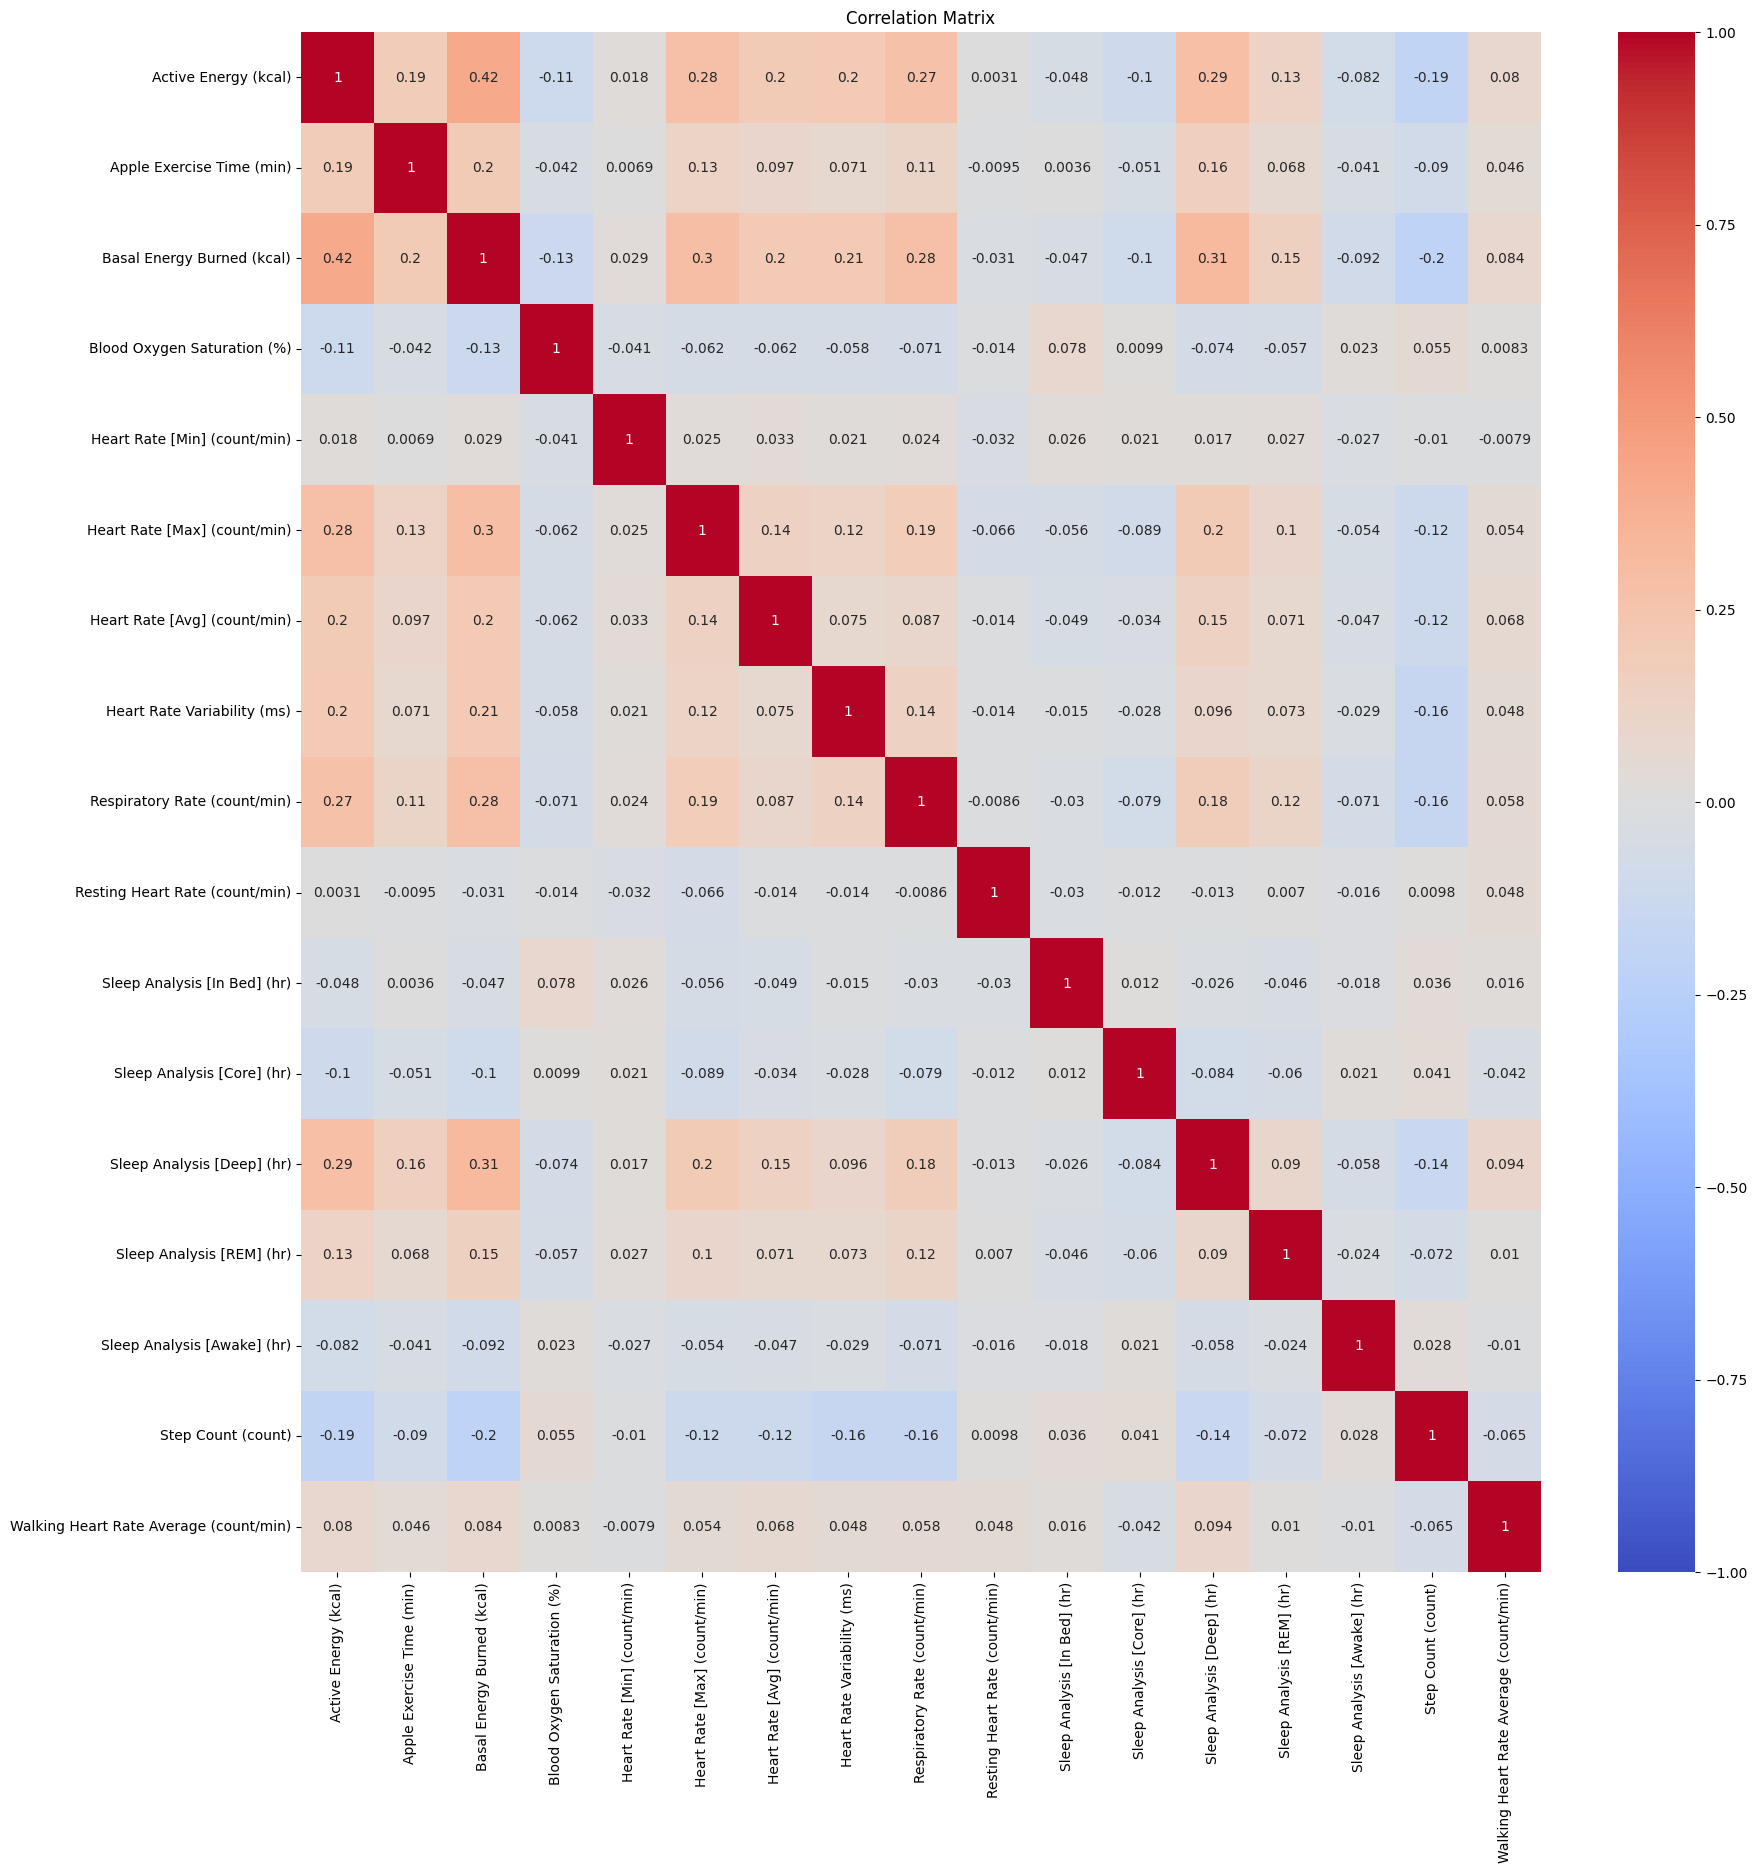

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the correlation matrix array to a DataFrame
correlation_df = pd.DataFrame(correlation_matrix_array, columns=cor_stress.columns, index=cor_stress.columns)

# Create a heatmap plot of the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

##EDA

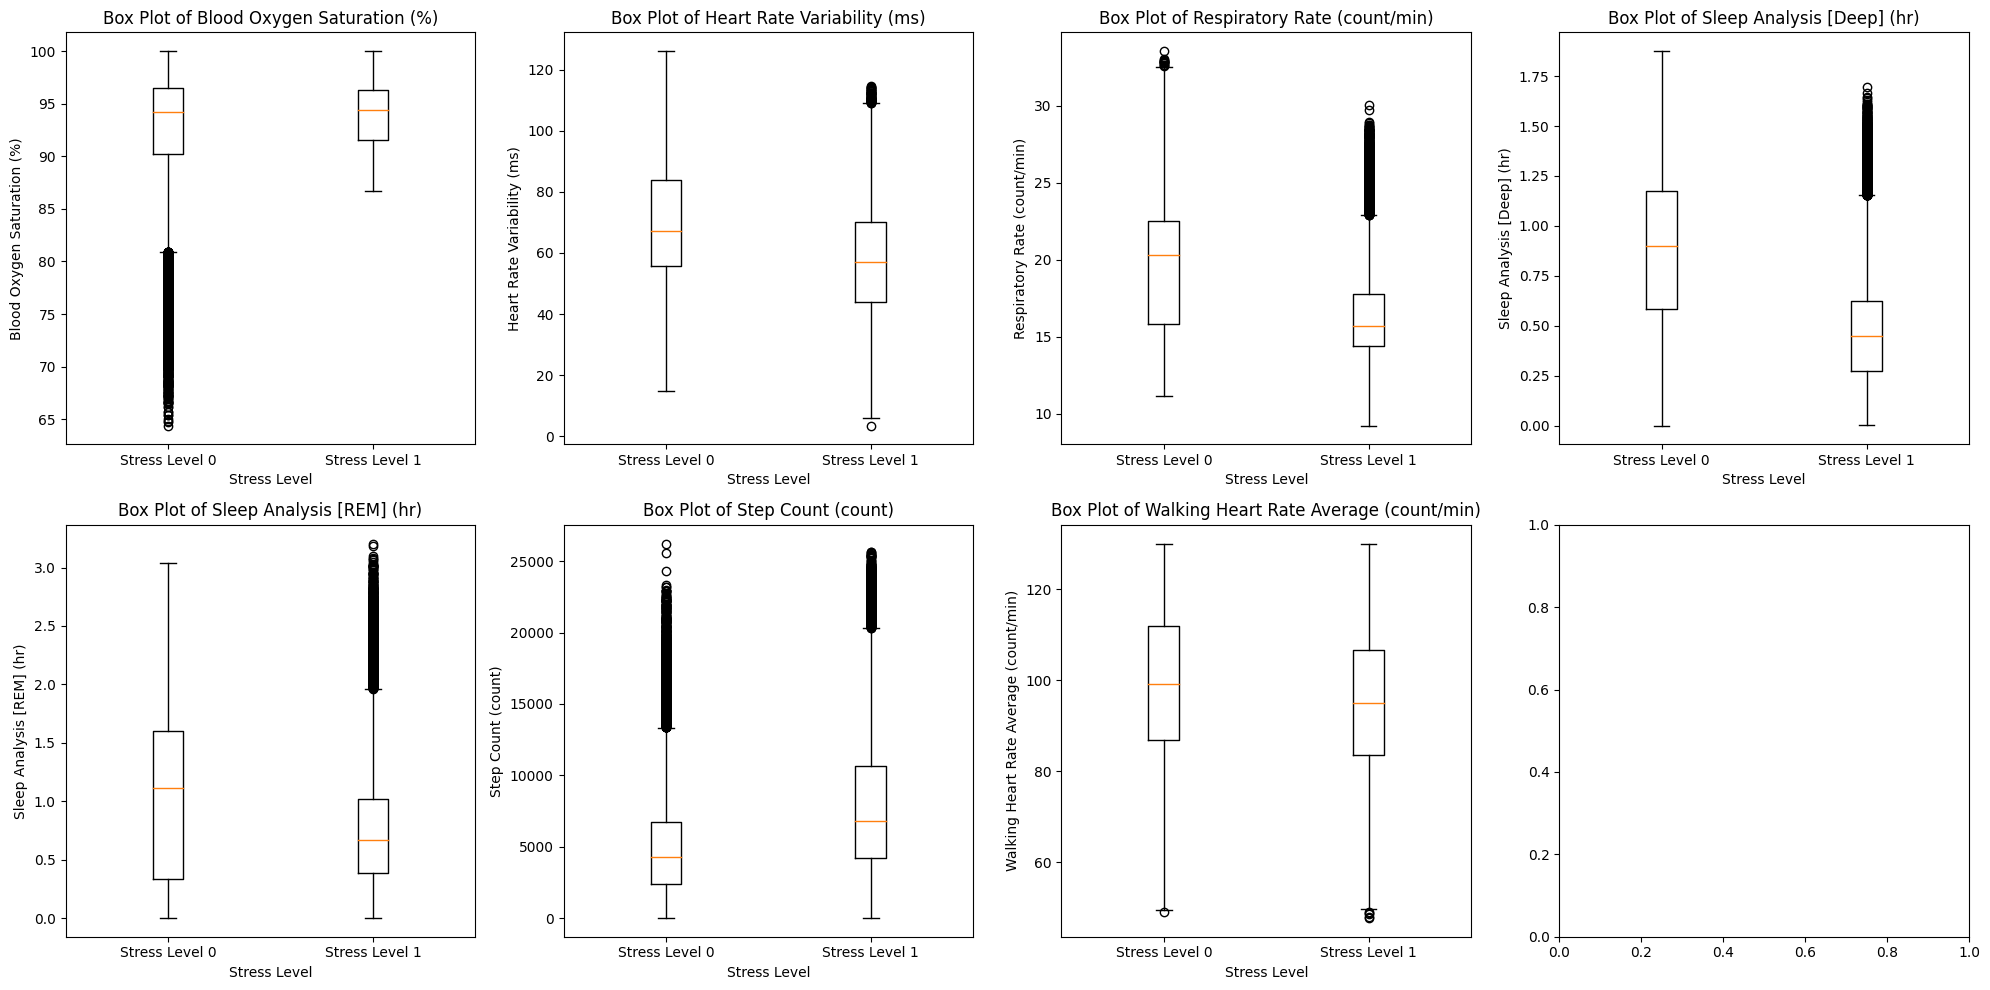

Percentage of outliers for Stress Level 0:
Blood Oxygen Saturation (%)               5.0
Heart Rate Variability (ms)               5.0
Respiratory Rate (count/min)              5.0
Sleep Analysis [Deep] (hr)                5.0
Sleep Analysis [REM] (hr)                 5.0
Step Count (count)                        5.0
Walking Heart Rate Average (count/min)    5.0
dtype: float64
Percentage of outliers for Stress Level 1:
Blood Oxygen Saturation (%)               5.0
Heart Rate Variability (ms)               5.0
Respiratory Rate (count/min)              5.0
Sleep Analysis [Deep] (hr)                5.0
Sleep Analysis [REM] (hr)                 5.0
Step Count (count)                        5.0
Walking Heart Rate Average (count/min)    5.0
dtype: float64


In [ ]:
# Convert the PySpark DataFrame to a pandas DataFrame for plotting
pandas_df = stress.select('Stress Level', 'Blood Oxygen Saturation (%)', 
                          'Heart Rate Variability (ms)', 'Respiratory Rate (count/min)', 
                          'Sleep Analysis [Deep] (hr)', 'Sleep Analysis [REM] (hr)', 
                          'Step Count (count)', 'Walking Heart Rate Average (count/min)').toPandas()

# Subset the data for stress level 0 and 1
stress_0_data = pandas_df[pandas_df['Stress Level'] == 0]
stress_1_data = pandas_df[pandas_df['Stress Level'] == 1]

# Select the relevant variables for the box plots
variables = ['Blood Oxygen Saturation (%)', 'Heart Rate Variability (ms)', 
             'Respiratory Rate (count/min)', 'Sleep Analysis [Deep] (hr)', 
             'Sleep Analysis [REM] (hr)', 'Step Count (count)', 
             'Walking Heart Rate Average (count/min)']

# Create box plots for stress level 0 and 1 side by side
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for i, variable in enumerate(variables):
    row = i // 4
    col = i % 4
    axes[row, col].boxplot([stress_0_data[variable], stress_1_data[variable]], labels=['Stress Level 0', 'Stress Level 1'])
    axes[row, col].set_title(f'Box Plot of {variable}')
    axes[row, col].set_xlabel('Stress Level')
    axes[row, col].set_ylabel(variable)
plt.tight_layout()
plt.show()

outlier_percentage_0 = (stress_0_data[variables] > stress_0_data[variables].quantile(0.95)).mean() * 100
outlier_percentage_1 = (stress_1_data[variables] > stress_1_data[variables].quantile(0.95)).mean() * 100

print("Percentage of outliers for Stress Level 0:")
print(outlier_percentage_0)

print("Percentage of outliers for Stress Level 1:")
print(outlier_percentage_1)

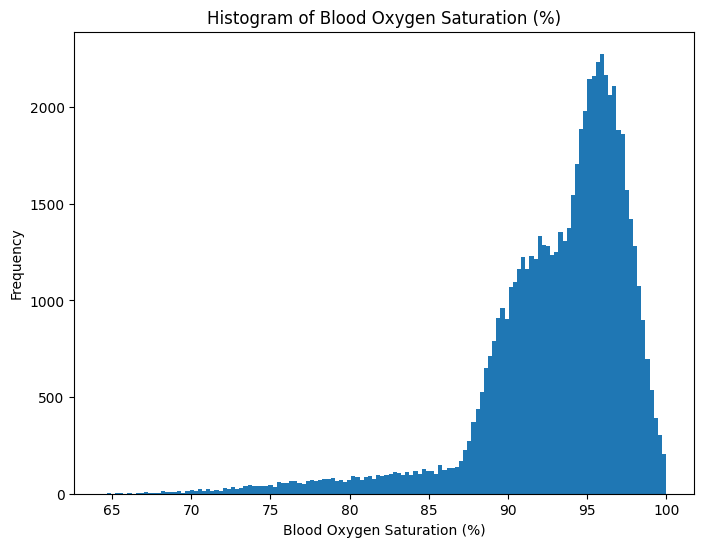

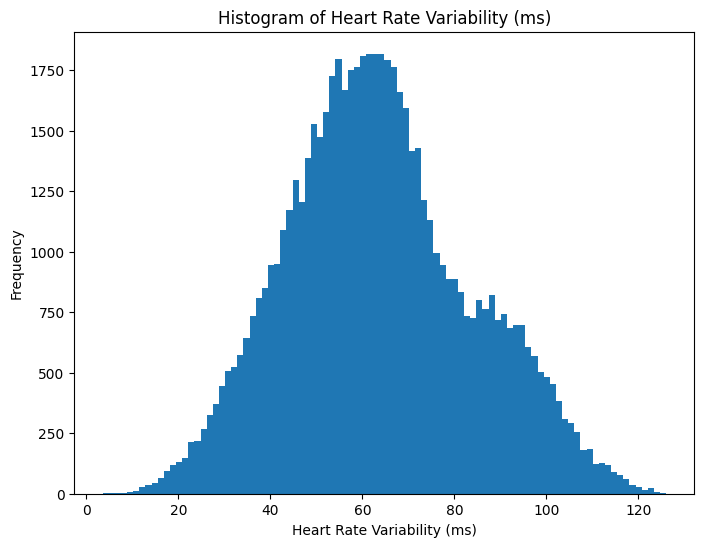

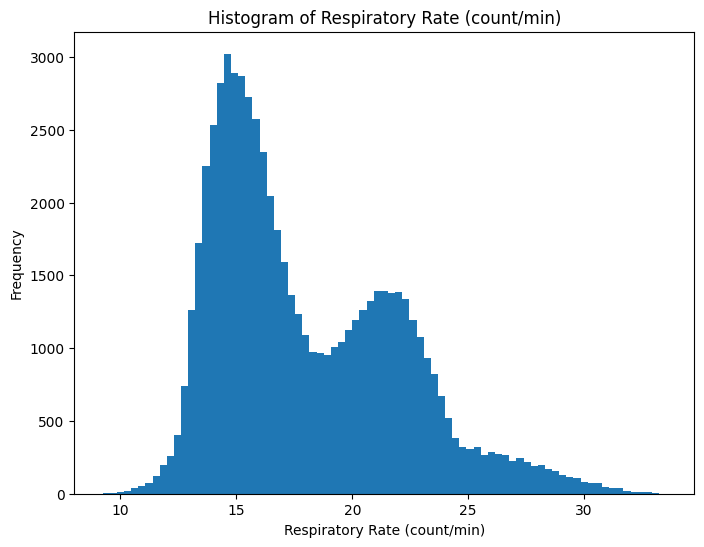

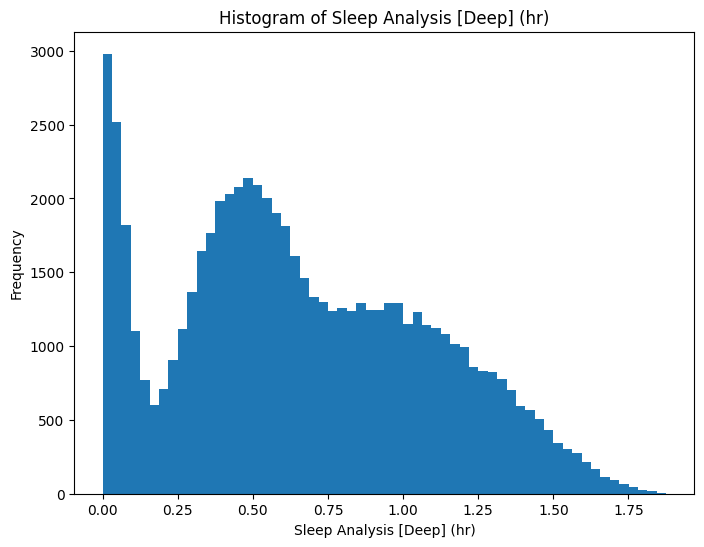

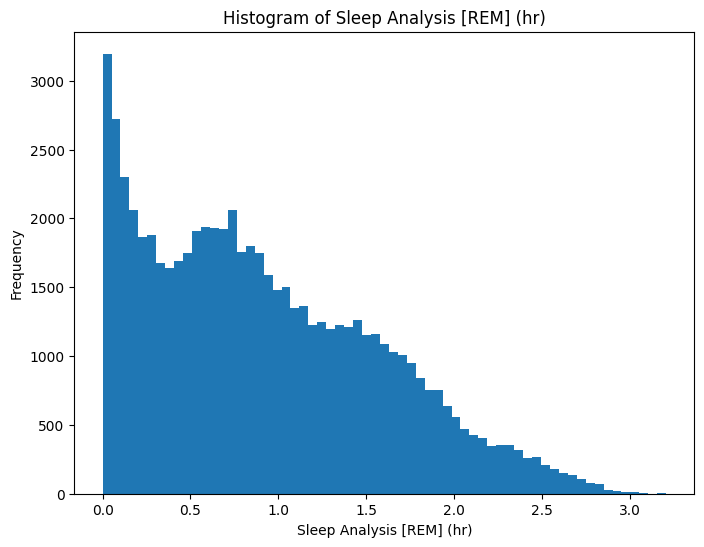

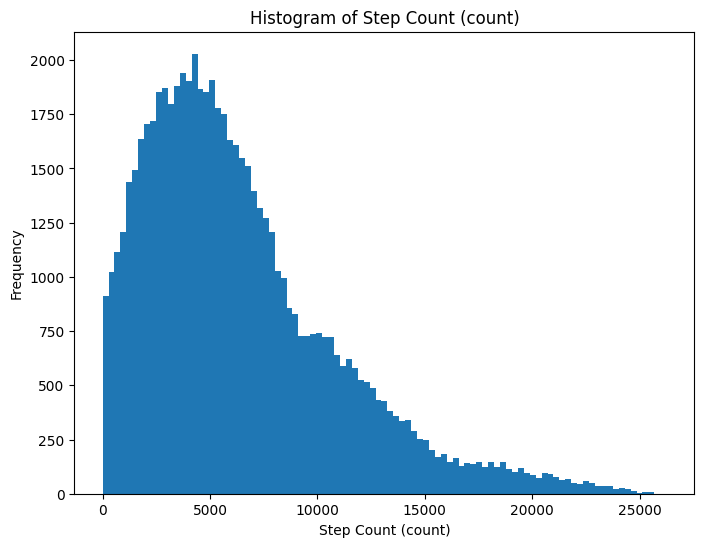

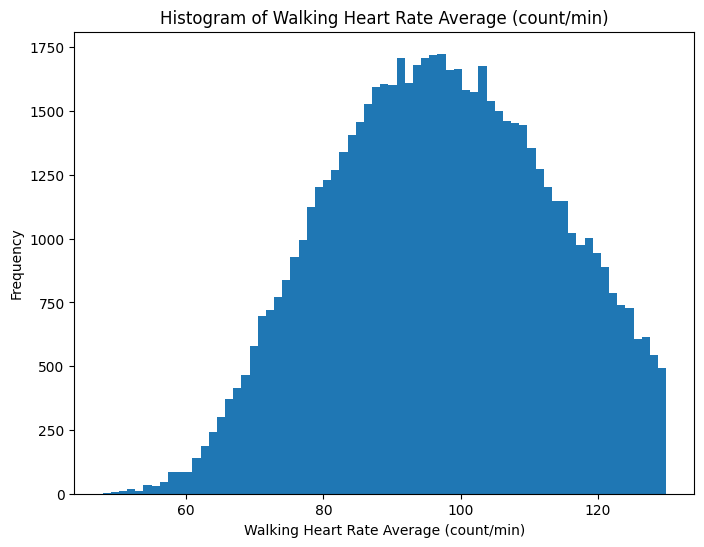

In [ ]:
# Get the list of variables
variables = pandas_df.columns[1:]  # Exclude the 'Stress Level' column

# Plot histograms for each variable
for variable in variables:
    plt.figure(figsize=(8, 6))
    plt.hist(pandas_df[variable], bins='auto')
    plt.title(f'Histogram of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.show()

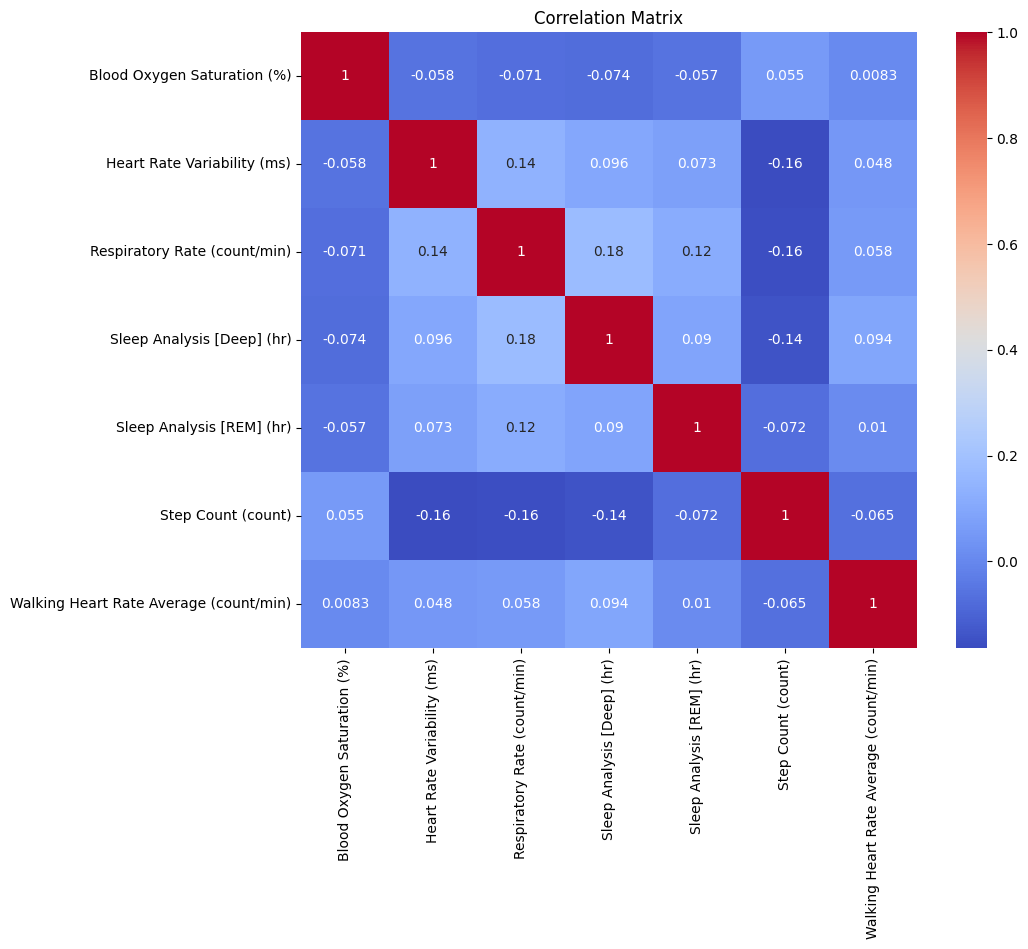

In [ ]:
# Convert the PySpark DataFrame to a pandas DataFrame
pandas_cor_df = stress.select(['Blood Oxygen Saturation (%)', 
                              'Heart Rate Variability (ms)', 'Respiratory Rate (count/min)', 
                              'Sleep Analysis [Deep] (hr)', 'Sleep Analysis [REM] (hr)', 
                              'Step Count (count)', 'Walking Heart Rate Average (count/min)']).toPandas()

# Calculate the correlation matrix
correlation_matrix = pandas_cor_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

## Modelling

In [ ]:
stress.createOrReplaceTempView("stress")
#Compute rolling average of variables from t=1 to t=30
rolling_avg_dataset_30 = spark.sql("""
    SELECT User, `stress`.`Stress Level`, Time as Thirtydf_Time,
    avg(`Blood Oxygen Saturation (%)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Blood_Oxygen_Saturation_ra30`,
    avg(`Heart Rate Variability (ms)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Heart_Rate_Variability_ra30`,
    avg(`Respiratory Rate (count/min)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Respiratory_Rate__ra30`,
    avg(`Sleep Analysis [Deep] (hr)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Sleep_Analysis_deep_ra30`,
    avg(`Sleep Analysis [REM] (hr)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Sleep_Analysis_REM_ra30`,
    avg(`Step Count (count)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Step_Count_ra30`
    FROM stress
    WHERE Time BETWEEN 1 AND 30
""")
rolling_avg_dataset_30.createOrReplaceTempView("Thirty_df")
#Fetch the rolling average at t=30 for each user
Thirty_df = spark.sql("SELECT * FROM Thirty_df WHERE Thirtydf_Time = 30")
Thirty_df.show(50)


+----+------------+-------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|User|Stress Level|Thirtydf_Time|Blood_Oxygen_Saturation_ra30|Heart_Rate_Variability_ra30|Respiratory_Rate__ra30|Sleep_Analysis_deep_ra30|Sleep_Analysis_REM_ra30|   Step_Count_ra30|
+----+------------+-------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|   1|           0|           30|           90.17310602333332|               71.399083024|          19.478113223|      0.7167358609000002|           1.1636478994| 4748.391166600933|
|   2|           0|           30|           94.24925293266668|          77.26411075200002|    20.782644123666667|      0.7494325090333332|     1.0641902318666665| 4910.725826199999|
|   3|           0|           30|           92.74161999866665|               66.149360736|

In [ ]:
#Compute rolling average of variables from t=31 to t=60
rolling_avg_dataset_60 = spark.sql("""
    SELECT User, Time as Sixtydf_Time,
    avg(`Blood Oxygen Saturation (%)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Blood_Oxygen_Saturation_ra60`,
    avg(`Heart Rate Variability (ms)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Heart_Rate_Variability_ra60`,
    avg(`Respiratory Rate (count/min)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Respiratory_Rate__ra60`,
    avg(`Sleep Analysis [Deep] (hr)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Sleep_Analysis_deep_ra60`,
    avg(`Sleep Analysis [REM] (hr)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Sleep_Analysis_REM_ra60`,
    avg(`Step Count (count)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Step_Count_ra60`
    FROM stress
    WHERE Time BETWEEN 1 AND 60
""")
rolling_avg_dataset_60.createOrReplaceTempView("Sixty_df")
#Fetch the rolling average at t=60 for each user
Sixty_df=spark.sql("Select * from  Sixty_df where Sixtydf_Time=60 ")
Sixty_df.show(50)


+----+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|User|Sixtydf_Time|Blood_Oxygen_Saturation_ra60|Heart_Rate_Variability_ra60|Respiratory_Rate__ra60|Sleep_Analysis_deep_ra60|Sleep_Analysis_REM_ra60|   Step_Count_ra60|
+----+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|   1|          60|           91.28018374416666|          72.37118199049998|    19.425009532500006|      0.8277018358166669|     1.1581358392000003| 5059.925416657134|
|   3|          60|           92.57768689199999|               69.743817873|    19.582162665166667|      0.8318137786666663|      1.002437916483333| 5630.597604594998|
|   5|          60|           91.50143431566669|          71.34933130050003|    19.969382886499993|      0.7998433288000002|     1.0788127881333334| 4666.940079

In [ ]:
#Compute rolling average of variables from t=61 to t=90
rolling_avg_dataset_90 = spark.sql("""
    SELECT User, Time as Nintydf_Time,
    avg(`Blood Oxygen Saturation (%)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Blood_Oxygen_Saturation_ra90`,
    avg(`Heart Rate Variability (ms)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Heart_Rate_Variability_ra90`,
    avg(`Respiratory Rate (count/min)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Respiratory_Rate__ra90`,
    avg(`Sleep Analysis [Deep] (hr)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Sleep_Analysis_deep_ra90`,
    avg(`Sleep Analysis [REM] (hr)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Sleep_Analysis_REM_ra90`,
    avg(`Step Count (count)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Step_Count_ra90`
    FROM stress
    WHERE Time BETWEEN 1 AND 90
""")

rolling_avg_dataset_90.createOrReplaceTempView("Ninty_df")
#Fetch the rolling average at t=90 for each user
Ninty_df=spark.sql("Select * from  Ninty_df where Nintydf_Time=90 ")
Ninty_df.show(50)


+----+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|User|Nintydf_Time|Blood_Oxygen_Saturation_ra90|Heart_Rate_Variability_ra90|Respiratory_Rate__ra90|Sleep_Analysis_deep_ra90|Sleep_Analysis_REM_ra90|   Step_Count_ra90|
+----+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|   1|          90|           91.11124431311111|          72.01768323866665|     19.76750648988889|      0.8388387334444443|     1.1454685100555557| 5363.928465109201|
|   3|          90|           92.71463354566666|          71.28987877533335|    19.975523516555562|      0.8630454055111108|     0.9612705722666661|5016.9665064366645|
|   5|          90|                91.882369783|          72.75369991766668|     20.01720213155555|      0.8225503586888888|      1.093557766944444|  4880.19897

In [ ]:
#Joined all dataframes
joined_table = Ninty_df.join(Sixty_df, "User").join(Thirty_df, "User")

# Displaying the result
joined_table.show()


+----+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+------------+-------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|User|Nintydf_Time|Blood_Oxygen_Saturation_ra90|Heart_Rate_Variability_ra90|Respiratory_Rate__ra90|Sleep_Analysis_deep_ra90|Sleep_Analysis_REM_ra90|   Step_Count_ra90|Sixtydf_Time|Blood_Oxygen_Saturation_ra60|Heart_Rate_Variability_ra60|Respiratory_Rate__ra60|Sleep_Analysis_deep_ra60|Sleep_Analysis_REM_ra60|   Step_Count_ra60|Stress Level|Thirtydf_Time|Blood_Oxygen_Saturation_ra30|Heart_Rate_Variability_ra30|Respiratory_Rate__ra30|Sleep_Analysis_deep_ra30|Sleep_Analysis_REM_ra30|   Step_Coun

In [ ]:
#Drop unnecessary columsn from dataframe
drop_columns = ['User', 'Nintydf_Time','Sixtydf_Time','Thirtydf_Time'] 
selected_data = joined_table.drop(*drop_columns)

# Show the resulting DataFrame
selected_data.show()


+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|Blood_Oxygen_Saturation_ra90|Heart_Rate_Variability_ra90|Respiratory_Rate__ra90|Sleep_Analysis_deep_ra90|Sleep_Analysis_REM_ra90|   Step_Count_ra90|Blood_Oxygen_Saturation_ra60|Heart_Rate_Variability_ra60|Respiratory_Rate__ra60|Sleep_Analysis_deep_ra60|Sleep_Analysis_REM_ra60|   Step_Count_ra60|Stress Level|Blood_Oxygen_Saturation_ra30|Heart_Rate_Variability_ra30|Respiratory_Rate__ra30|Sleep_Analysis_deep_ra30|Sleep_Analysis_REM_ra30|   Step_Count_ra30|
+----------------------------+---------------------------+----------------------+-

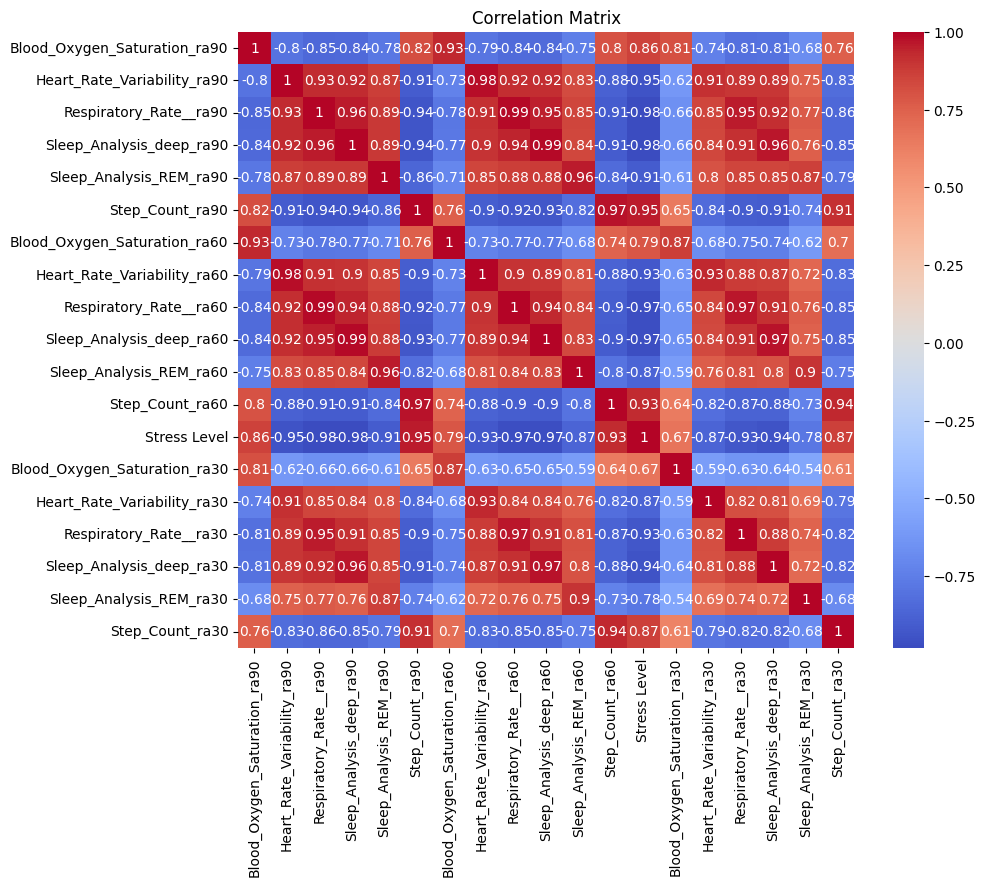

In [ ]:
# Convert the PySpark DataFrame to a pandas DataFrame
pandas_scor_df = selected_data.toPandas()

# Calculate the correlation matrix
correlation_matrix = pandas_scor_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Assemble the features into a vector column
feature_columns = [col_name for col_name in selected_data.columns if col_name not in ['Stress Level']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_data = assembler.transform(selected_data)

# Select the 'Stress Level' and 'features' columns
selected_data_final = assembled_data.select('Stress Level', 'features')
selected_data_final.show()

+------------+--------------------+
|Stress Level|            features|
+------------+--------------------+
|           0|[91.1112443131111...|
|           0|[92.7146335456666...|
|           0|[91.882369783,72....|
|           0|[92.1087096816666...|
|           0|[92.0571355961111...|
|           0|[93.7885875975555...|
|           0|[93.5309818401111...|
|           0|[93.3591838116666...|
|           0|[92.2368976167777...|
|           0|[92.4123101274444...|
|           0|[91.5309727165555...|
|           0|[93.0916840725556...|
|           0|[92.9534398230000...|
|           0|[92.0913989617777...|
|           0|[92.6721880636666...|
|           0|[92.3483222090000...|
|           0|[92.0073678263333...|
|           0|[92.2556377543333...|
|           0|[92.7051364217777...|
|           0|[91.7161226217777...|
+------------+--------------------+
only showing top 20 rows



In [ ]:
#Perform simialr steps for test data
original_data=original_data.drop('_c20')
original_data = original_data.fillna(0)
selected_columns =['User']+['Time']+['Stress Level'] +['Blood Oxygen Saturation (%)']+['Heart Rate Variability (ms)']+['Respiratory Rate (count/min)']+['Sleep Analysis [Deep] (hr)']+['Sleep Analysis [REM] (hr)']+['Step Count (count)']
original_data=original_data.select(selected_columns)
original_data.show()

+----+----+------------+---------------------------+---------------------------+----------------------------+--------------------------+-------------------------+------------------+
|User|Time|Stress Level|Blood Oxygen Saturation (%)|Heart Rate Variability (ms)|Respiratory Rate (count/min)|Sleep Analysis [Deep] (hr)|Sleep Analysis [REM] (hr)|Step Count (count)|
+----+----+------------+---------------------------+---------------------------+----------------------------+--------------------------+-------------------------+------------------+
|   2|   1|           1|                       97.0|                      42.21|                       14.65|                      0.95|                     1.05|            2536.0|
|   2|   2|           1|                      97.43|                      50.41|                       14.48|               0.883333333|              1.333333333|            3185.0|
|   2|   3|           1|                      94.83|                      31.69|          

In [ ]:
#Fetch the rolling average of data for each user from t=1 to t=30
original_data.createOrReplaceTempView("original_data")
or_rolling_avg_dataset_30 = spark.sql("""
    SELECT User, `original_data`.`Stress Level`, Time as Thirtydf_Time,
    avg(`Blood Oxygen Saturation (%)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Blood_Oxygen_Saturation_ra30`,
    avg(`Heart Rate Variability (ms)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Heart_Rate_Variability_ra30`,
    avg(`Respiratory Rate (count/min)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Respiratory_Rate__ra30`,
    avg(`Sleep Analysis [Deep] (hr)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Sleep_Analysis_deep_ra30`,
    avg(`Sleep Analysis [REM] (hr)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Sleep_Analysis_REM_ra30`,
    avg(`Step Count (count)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Step_Count_ra30`
    FROM original_data
    WHERE Time BETWEEN 1 AND 30
""")
or_rolling_avg_dataset_30.createOrReplaceTempView("OrThirty_df")
OrThirty_df = spark.sql("SELECT * FROM OrThirty_df WHERE Thirtydf_Time = 30")
OrThirty_df.show(50)

+----+------------+-------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|User|Stress Level|Thirtydf_Time|Blood_Oxygen_Saturation_ra30|Heart_Rate_Variability_ra30|Respiratory_Rate__ra30|Sleep_Analysis_deep_ra30|Sleep_Analysis_REM_ra30|   Step_Count_ra30|
+----+------------+-------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|   2|           1|           30|                97.672960784|         48.334616438000005|    15.420580460333328|      0.6059017093333333|     0.8024230769333331|            3678.6|
|   3|           0|           30|                      96.452|         52.890999999999984|                21.128|      0.9558333333666665|     1.1980555556000003| 7106.433333333333|
|   4|           0|           30|           96.27733333333335|          47.21933333333333|

In [ ]:
#Fetch the rolling average of data for each user from t=1 to t=60
or_rolling_avg_dataset_60 = spark.sql("""
    SELECT User, Time as Sixtydf_Time,
    avg(`Blood Oxygen Saturation (%)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Blood_Oxygen_Saturation_ra60`,
    avg(`Heart Rate Variability (ms)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Heart_Rate_Variability_ra60`,
    avg(`Respiratory Rate (count/min)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Respiratory_Rate__ra60`,
    avg(`Sleep Analysis [Deep] (hr)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Sleep_Analysis_deep_ra60`,
    avg(`Sleep Analysis [REM] (hr)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Sleep_Analysis_REM_ra60`,
    avg(`Step Count (count)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Step_Count_ra60`
    FROM original_data
    WHERE Time BETWEEN 1 AND 60
""")
or_rolling_avg_dataset_60.createOrReplaceTempView("OrSixty_df")
OrSixty_df = spark.sql("SELECT * FROM OrSixty_df WHERE Sixtydf_Time = 60")
OrSixty_df.show(50)

+----+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|User|Sixtydf_Time|Blood_Oxygen_Saturation_ra60|Heart_Rate_Variability_ra60|Respiratory_Rate__ra60|Sleep_Analysis_deep_ra60|Sleep_Analysis_REM_ra60|   Step_Count_ra60|
+----+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|   2|          60|           97.88043627399995|               46.819424657|     15.59427011566666|      0.5186645298666667|     0.7171794872333336|3688.0333333333333|
|   3|          60|           96.17633333333332|          51.69566666666666|    20.890499999999996|      0.9523611110999999|     1.2284722222666666|            8028.5|
|   4|          60|           95.34966666666665|         47.027499999999996|    22.060999999999993|      0.8712054183833335|     1.0020164608166668|            

In [ ]:
#Fetch the rolling average of data for each user from t=1 to t=90
or_rolling_avg_dataset_90 = spark.sql("""
    SELECT User, Time as Nintydf_Time,
    avg(`Blood Oxygen Saturation (%)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Blood_Oxygen_Saturation_ra90`,
    avg(`Heart Rate Variability (ms)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Heart_Rate_Variability_ra90`,
    avg(`Respiratory Rate (count/min)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Respiratory_Rate__ra90`,
    avg(`Sleep Analysis [Deep] (hr)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Sleep_Analysis_deep_ra90`,
    avg(`Sleep Analysis [REM] (hr)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Sleep_Analysis_REM_ra90`,
    avg(`Step Count (count)`) OVER (PARTITION BY User ORDER BY Time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS `Step_Count_ra90`
    FROM original_data
    WHERE Time BETWEEN 1 AND 90
""")
or_rolling_avg_dataset_90.createOrReplaceTempView("OrNinty_df")
OrNinty_df = spark.sql("SELECT * FROM OrNinty_df WHERE Nintydf_Time = 90")
OrNinty_df.show(50)

+----+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|User|Nintydf_Time|Blood_Oxygen_Saturation_ra90|Heart_Rate_Variability_ra90|Respiratory_Rate__ra90|Sleep_Analysis_deep_ra90|Sleep_Analysis_REM_ra90|   Step_Count_ra90|
+----+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|   2|          90|           97.82136928044437|          46.47512176488889|     15.55695977099999|     0.47029629625555536|     0.6819814815444449| 4105.344444444445|
|   3|          90|           96.10533333333333|          51.24700000000001|    21.031888888888886|      0.8883333332999999|     1.1695370370444444| 8464.777777777777|
|   4|          90|                      95.649|         48.994333333333344|    21.998999999999995|      0.8930258345111111|     0.9807887517111114| 8265.788888

In [ ]:
#Joined all these datafrmae into one
orjoined_table = OrNinty_df.join(OrSixty_df, "User").join(OrThirty_df, "User")

# Displaying the result
orjoined_table.show()


+----+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+------------+-------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|User|Nintydf_Time|Blood_Oxygen_Saturation_ra90|Heart_Rate_Variability_ra90|Respiratory_Rate__ra90|Sleep_Analysis_deep_ra90|Sleep_Analysis_REM_ra90|   Step_Count_ra90|Sixtydf_Time|Blood_Oxygen_Saturation_ra60|Heart_Rate_Variability_ra60|Respiratory_Rate__ra60|Sleep_Analysis_deep_ra60|Sleep_Analysis_REM_ra60|   Step_Count_ra60|Stress Level|Thirtydf_Time|Blood_Oxygen_Saturation_ra30|Heart_Rate_Variability_ra30|Respiratory_Rate__ra30|Sleep_Analysis_deep_ra30|Sleep_Analysis_REM_ra30|   Step_Coun

In [ ]:
drop_columns = ['User', 'Nintydf_Time','Sixtydf_Time','Thirtydf_Time']  # Specify the table name or alias
original_data_final = orjoined_table.drop(*drop_columns)

# Show the resulting DataFrame
original_data_final.show()

# Assemble the features into a vector column
feature_columns = [col_name for col_name in original_data_final.columns if col_name not in ['Stress Level']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_data = assembler.transform(original_data_final)

# Select the 'Stress Level' and 'features' columns
original_data_final = assembled_data.select('Stress Level', 'features')
original_data_final.show()

+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+------------+----------------------------+---------------------------+----------------------+------------------------+-----------------------+------------------+
|Blood_Oxygen_Saturation_ra90|Heart_Rate_Variability_ra90|Respiratory_Rate__ra90|Sleep_Analysis_deep_ra90|Sleep_Analysis_REM_ra90|   Step_Count_ra90|Blood_Oxygen_Saturation_ra60|Heart_Rate_Variability_ra60|Respiratory_Rate__ra60|Sleep_Analysis_deep_ra60|Sleep_Analysis_REM_ra60|   Step_Count_ra60|Stress Level|Blood_Oxygen_Saturation_ra30|Heart_Rate_Variability_ra30|Respiratory_Rate__ra30|Sleep_Analysis_deep_ra30|Sleep_Analysis_REM_ra30|   Step_Count_ra30|
+----------------------------+---------------------------+----------------------+-

## Logistic Regression

In [ ]:
# Create a LogisticRegression model
lr = LogisticRegression(labelCol='Stress Level', featuresCol='features')

# Fit the model to the training data
lr_model = lr.fit(selected_data_final)

# Make predictions on the test data
predictions = lr_model.transform(original_data_final)
# Show the predictions
# predictions.show()
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Evaluate the accuracy of the predictions
evaluator = MulticlassClassificationEvaluator(labelCol='Stress Level', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

# Print the accuracy
print("Accuracy: {:.2%}".format(accuracy))

# Compute precision, recall, and confusion matrix
labels = predictions.select('Stress Level').distinct().orderBy('Stress Level').rdd.flatMap(lambda x: x).collect()
num_labels = len(labels)
confusion_matrix = predictions.groupBy('Stress Level').pivot('prediction', labels).count().na.fill(0).orderBy('Stress Level').toPandas()
confusion_matrix.rename(columns={'Stress Level': 'True/Predicted'}, inplace=True)
confusion_matrix.set_index('True/Predicted', inplace=True)

# Compute precision and recall
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)

print("Precision: ")
print(precision)
print("Recall: ")
print(recall)
print("Confusion Matrix: ")
print(confusion_matrix)

Accuracy: 72.73%
Precision: 
0    0.666667
1    0.750000
dtype: float64
Recall: 
True/Predicted
0    0.500000
1    0.857143
dtype: float64
Confusion Matrix: 
                0  1
True/Predicted      
0               2  2
1               1  6


## Lasso and Logistic Regression

In [ ]:
# Create a Logistic Regression model with L1 regularization for multi-class classification
feature_columns = [col_name for col_name in selected_data_final.columns if col_name != 'Stress Level']

# Convert the input data (selected_data_final) into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="rawFeatures")
df_features = assembler.transform(selected_data_final)

# Scale the features using StandardScaler
scaler = StandardScaler(inputCol="rawFeatures", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

# Create a Logistic Regression model with L1 regularization for multi-class classification
logistic = LogisticRegression(featuresCol='scaledFeatures', labelCol='Stress Level', regParam=0.1, elasticNetParam=1.0)

# Fit the model to the scaled training data
logistic_model = logistic.fit(df_scaled)

# Transform the original data using the scaler_model
df_features_test = assembler.transform(original_data_final)
df_scaled_test = scaler_model.transform(df_features_test)

# Make predictions on the test data
predictions = logistic_model.transform(df_scaled_test)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='Stress Level', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print('Accuracy:', accuracy)

# Retrieve the coefficients and intercepts for each class
coefficients = logistic_model.coefficientMatrix
intercepts = logistic_model.interceptVector
print('Coefficients:', coefficients)
print('Intercepts:', intercepts)

# Compute precision, recall, and confusion matrix
labels = predictions.select('Stress Level').distinct().orderBy('Stress Level').rdd.flatMap(lambda x: x).collect()
num_labels = len(labels)
confusion_matrix = predictions.groupBy('Stress Level').pivot('prediction', labels).count().na.fill(0).orderBy('Stress Level').toPandas()
confusion_matrix.rename(columns={'Stress Level': 'True/Predicted'}, inplace=True)
confusion_matrix.set_index('True/Predicted', inplace=True)

# Compute precision and recall
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)

print("Precision: ")
print(precision)
print("Recall: ")
print(recall)
print("Confusion Matrix: ")
print(confusion_matrix)

Accuracy: 0.8181818181818182
Coefficients: 1 X 18 CSRMatrix
(0,1) -0.0397
(0,2) -0.8919
(0,3) -1.2004
(0,5) 0.0839
Intercepts: [13.46957564898748]
Precision: 
0    1.000000
1    0.777778
dtype: float64
Recall: 
True/Predicted
0    0.5
1    1.0
dtype: float64
Confusion Matrix: 
                0  1
True/Predicted      
0               2  2
1               0  7


## Random Forest

In [ ]:
# Create a Random Forest Classifier for multi-class classification
feature_columns = [col_name for col_name in selected_data_final.columns if col_name != 'Stress Level']
random_forest = RandomForestClassifier(featuresCol='features', labelCol='Stress Level')

# Fit the model to the training data
random_forest_model = random_forest.fit(selected_data_final)

# Make predictions on the test data
predictions = random_forest_model.transform(original_data_final)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='Stress Level', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print('Accuracy:', accuracy)

# Retrieve the feature importances
importances = random_forest_model.featureImportances
print('Feature Importances:', importances)

# Compute precision, recall, and confusion matrix
labels = predictions.select('Stress Level').distinct().orderBy('Stress Level').rdd.flatMap(lambda x: x).collect()
num_labels = len(labels)
confusion_matrix = predictions.groupBy('Stress Level').pivot('prediction', labels).count().na.fill(0).orderBy('Stress Level').toPandas()
confusion_matrix.rename(columns={'Stress Level': 'True/Predicted'}, inplace=True)
confusion_matrix.set_index('True/Predicted', inplace=True)

# Compute precision and recall
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)

print("Precision: ")
print(precision)
print("Recall: ")
print(recall)
print("Confusion Matrix: ")
print(confusion_matrix)

Accuracy: 0.6363636363636364
Feature Importances: (18,[0,1,2,3,4,5,7,8,9,11,14,15,17],[0.0011135203215951737,0.10114274701262797,0.09860010665741421,0.34638675001552655,0.0008404457088667615,0.00026494679952710604,0.0011733072498263818,0.0016063694080726426,0.04973841343280172,0.1482594868720507,0.14982568785474334,0.09997863866606055,0.001069580000887006])
Precision: 
0         NaN
1    0.636364
dtype: float64
Recall: 
True/Predicted
0    0.0
1    1.0
dtype: float64
Confusion Matrix: 
                0  1
True/Predicted      
0               0  4
1               0  7


## Ridge and Logistic Regression

In [ ]:
# Convert the input data (selected_data_final) into a feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="assembled_features")
df_features = assembler.transform(selected_data_final)

# Scale the features using StandardScaler
scaler = StandardScaler(inputCol="assembled_features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

# Create a Logistic Regression model with L1 regularization for multi-class classification
logistic = LogisticRegression(featuresCol='scaledFeatures', labelCol='Stress Level', regParam=0.1, elasticNetParam=0.0)

# Fit the model to the scaled training data
logistic_model = logistic.fit(df_scaled)

# Transform the original data using the scaler_model
df_features_test = assembler.transform(original_data_final)
df_scaled_test = scaler_model.transform(df_features_test)

# Make predictions on the test data
predictions = logistic_model.transform(df_scaled_test)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='Stress Level', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print('Accuracy:', accuracy)

# Retrieve the coefficients and intercepts for each class
coefficients = logistic_model.coefficientMatrix
intercepts = logistic_model.interceptVector
print('Coefficients:', coefficients)
print('Intercepts:', intercepts)

# Compute precision, recall, and confusion matrix
labels = predictions.select('Stress Level').distinct().orderBy('Stress Level').rdd.flatMap(lambda x: x).collect()
num_labels = len(labels)
confusion_matrix = predictions.groupBy('Stress Level').pivot('prediction', labels).count().na.fill(0).orderBy('Stress Level').toPandas()
confusion_matrix.rename(columns={'Stress Level': 'True/Predicted'}, inplace=True)
confusion_matrix.set_index('True/Predicted', inplace=True)

# Compute precision and recall
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)

print("Precision: ")
print(precision)
print("Recall: ")
print(recall)
print("Confusion Matrix: ")
print(confusion_matrix)

Accuracy: 0.36363636363636365
Coefficients: DenseMatrix([[ 0.20506852, -0.2466081 , -0.26513278, -0.2710517 , -0.23184453,
               0.24943189,  0.17690824, -0.23429662, -0.25936465, -0.26505082,
              -0.21272314,  0.23282231,  0.13600226, -0.21028988, -0.24353133,
              -0.25599213, -0.17943182,  0.20892429]])
Intercepts: [-29.902871267790623]
Precision: 
0    0.0
1    0.5
dtype: float64
Recall: 
True/Predicted
0    0.000000
1    0.571429
dtype: float64
Confusion Matrix: 
                0  1
True/Predicted      
0               0  4
1               3  4
